<a href="https://colab.research.google.com/github/rmhiyye/-PubMed-Abstract-Classification/blob/main/notebooks/PubMed_Abstract_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 1: PubMed Abstract Classification (Pytorch Version)

###Student Infomation:

Name: Yang Ye

Email: rmhiyye@ucl.ac.uk

#0. Set Environment

In [ ]:
# check GPU information in colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jan 19 20:24:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Install neccessary libraries

In [ ]:
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torchtext==0.9.0

##Import neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torchtext.legacy import data
import nltk
nltk.download('stopwords')

# from google drive
from google.colab import drive
drive.mount("/content/drive")

import os
path = "/content/drive/My Drive/nlp-week1"
os.chdir(path)
os.listdir(path)

import Tokeniser

print('Done!')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive
Done!


# 1. Data Exploration

In [ ]:
# load the data from csv
df = pd.read_csv("mesh.csv")
# drop 'path' columns and drop the row with missing data
print("There is %d missing data in label." % df['label'].isnull().sum())
print("There is %d missing data in Text." % df['Text'].isnull().sum())
df = df.drop(columns = 'path')
df = df.dropna(axis = 0)
print("Missing data are removed.")

There is 0 missing data in label.
There is 1 missing data in Text.
Missing data are removed.


## Label overview

Distribution:
Eye Hemorrhage                  126
Pupil Disorders                 188
Scleral Diseases                201
Eye Injuries                    435
Refractive Errors               466
Ocular Hypertension             577
Lacrimal Apparatus Diseases     596
Conjunctival Diseases           750
Lens Diseases                   828
Eye Abnormalities               859
Eye Neoplasms                   917
Eye Infections                 1149
Eye Diseases, Hereditary       1245
Uveal Diseases                 1291
Corneal Diseases               1756
Optic Nerve Diseases           1809
Eyelid Diseases                1998
Ocular Motility Disorders      2508
Vision Disorders               2542
Orbital Diseases               2776
Retinal Diseases               4056
Name: label, dtype: int64


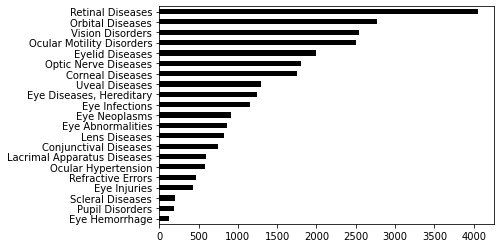

In [ ]:
# show the distribution for labels
counts = pd.value_counts(df['label'])
print('Distribution:')
print(pd.Series(counts).sort_values())
pd.Series(counts).sort_values().plot.barh(fontsize=10, color="k") # show the frequency of each label
# dataset is imbalanced

##Text length analysis

In [ ]:
df_len = [len(text.split()) for text in df.Text]
df_len_mean = round(np.mean(df_len))
df_len_max = round(np.max(df_len))
df_len_min = round(np.min(df_len))
print('Statistical results for texts length:')
print("mean:" + str(df_len_mean) +  "/ max:" + str(df_len_max) + "/ min:" + str(df_len_min))

Statistical results for texts length:
mean:125/ max:896/ min:8


Text(0.5, 0, 'number of tokens')

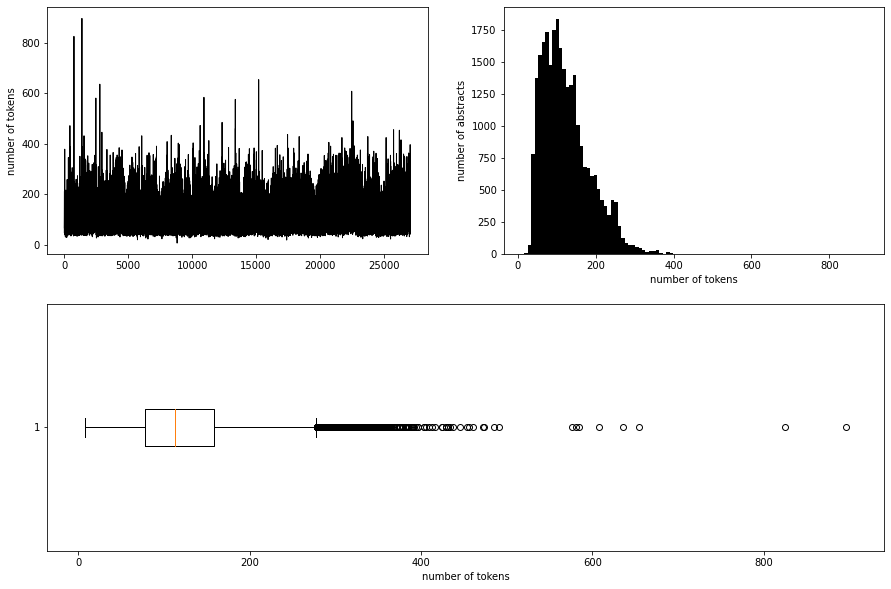

In [ ]:
# Visualization
fig = plt.figure(figsize = (15, 10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,1,2)
# line plot
N = len(df_len)
x = np.linspace(0, N, N)
ax1.plot(x, df_len, color = "black", linewidth = 1)
ax1.set_ylabel("number of tokens")
# histogram
ax2.hist(df_len, bins = 100, color = "black")
ax2.set_ylabel("number of abstracts")
ax2.set_xlabel("number of tokens")
# box plot
ax3.boxplot(df_len, vert = False)
ax3.set_xlabel("number of tokens")

#2. Data Preprocessing

In [ ]:
# split the data into training, validation and testing
df_train_valid, df_test = train_test_split(df, test_size=0.2)
df_train, df_valid = train_test_split(df_train_valid, test_size=0.3)
print((df_train).shape)
print((df_valid).shape)
print((df_test).shape)

# defines a datatype together with instructions for converting to Tensor
TEXT = data.Field(tokenize=Tokeniser.tokenise,include_lengths = True) # use Tokeniser.py
LABEL = data.LabelField()

(15160, 2)
(6498, 2)
(5415, 2)


In [ ]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False):
        examples = []
        for i, row in df.iterrows():
            label = row.label if not is_test else None
            text = row.Text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields)

    @staticmethod
    def sort_key(ex):
        return len(ex.Text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
fields = [('text',TEXT), ('label',LABEL)]

# package train_df and valid_df into {'text':Text,'label':label} format
train_ds, valid_ds, test_ds = DataFrameDataset.splits(fields, train_df=df_train, val_df=df_valid, test_df=df_test)

print(vars(train_ds[15]))
print(type(train_ds))

{'text': ['young', 'healthi', 'femal', 'present', 'acut', 'onset', 'left', 'ocular', 'pain', 'restrict', 'ocular', 'motil', 'binocular', 'diplopia', 'ct', 'imag', 'show', 'left', 'later', 'rectu', 'myositi', 'resolv', 'oral', 'corticosteroid', 'two', 'sequenti', 'relaps', 'occur', 'subsequ', 'involv', 'superior', 'rectu', 'levat', 'complex', 'follow', 'medial', 'rectu', 'biopsi', 'reveal', 'orbit', 'inflammatori', 'diseas', 'lymphocyt', ' ', 'vascul', 'detail', 'system', 'work', 'normal', 'second', 'relaps', 'seen', 'long', 'term', 'oral', 'methotrex', 'although', 'initi', 'diseas', 'remiss', ' ', 'achiev', 'drug', 'changeov', 'oral', 'azathioprin', 'abl', 'achiev', 'diseas', 'remiss', 'second', 'relaps', 'relaps', 'involv', 'side', 'contralater', 'orbit', 'affect', 'report', 'present', ' ', 'curiou', 'phenomenon', 'unilater', 'migratori', 'relaps', 'orbit', 'myositi', 'unknown', ' ', 'caus', 'recur', 'even', 'immunosuppress', 'therapi', 'highlight', 'unpredict', 'natur', 'uncommon', '

In [ ]:
TEXT.build_vocab(train_ds, 
        max_size = 25000, 
        vectors =  'glove.6B.100d',
        unk_init = torch.Tensor.zero_)
LABEL.build_vocab(train_ds)

#3. Define a model

In [ ]:
SEED = 50

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Hyperparameters
BATCH_SIZE = 128
num_epochs = 30
learning_rate = 0.0005

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(pd.Series(counts))
N_LAYERS = 2
BIDIRECTIONAL = True # Bidirectional LSTM
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding
TRAINING_TIME_LIMIT = 3600

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# defines an iterator that batches examples of similar lengths together
# (minimizes amount of padding needed)
train_iterator, valid_iterator , test_iterator = data.BucketIterator.splits(
    (train_ds, valid_ds, test_ds), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x:len(x.text),
    device = device)

cuda


In [ ]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)   
        self.rnn = nn.LSTM(embedding_dim, 
                  hidden_dim, 
                  num_layers = n_layers, 
                  bidirectional = bidirectional, 
                  dropout = dropout) 
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        # text = [sentence len, batch size]
        embedded = self.embedding(text)
        # embedded = [seq, batch_size, embedding_dimentions]
        # pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # packed_output = [sent len, batch size, hid dim * num directions]
        # packed_output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden) # and apply dropout
        output = self.fc(hidden)       
        #hidden = [batch size, hid dim * num directions]   
        return output

In [ ]:
# creating instance of our LSTM_net class
model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)
# show the model in detail
print(model)

LSTM_net(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=21, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
model.to(device)
# optimizer

LSTM_net(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 128, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=21, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
print('pretrained_embedding:',pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)
print('embedding layer inited.')

pretrained_embedding: torch.Size([25002, 100])
embedding layer inited.


In [ ]:
# to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4693, -0.5872, -0.3882,  ...,  0.7132, -0.2662,  0.0541],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')


In [ ]:
# initialize the weight (xavier)
def init_network(model, method='xavier', exclude='embedding'):
    for name, w in model.named_parameters():
        if exclude not in name:
            if 'weight' in name:
                if method == 'xavier':
                    nn.init.xavier_normal_(w)
                elif method == 'kaiming':
                    nn.init.kaiming_normal_(w)
                else:
                    nn.init.normal_(w)
            elif 'bias' in name:
                nn.init.constant_(w, 0)
            else:
                pass

# 4. Training Pharse

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
def accuracy(preds, y):
  # returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8.
  labels = y.data.cpu().numpy()
  predic = torch.max(preds.data, 1)[1].cpu().numpy()
  correct = (predic == labels)
  acc = correct.sum() / len(correct)
  return acc

In [ ]:
# training function for each epoch
def train(model, iterator):
    model.train()

    epoch_loss = 0
    epoch_acc = 0
    
    for batch in iterator:
        text, text_lengths = batch.text
        labels = batch.label

        optimizer.zero_grad()
        predictions = model(text, text_lengths.to('cpu')).squeeze(1)
        loss = nn.functional.cross_entropy(predictions,labels)

        acc = accuracy(predictions, labels)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# training evaluation for each epoch
def evaluate(model, iterator):
  epoch_acc = 0
  model.eval()
  loss_total = 0
  predict_all = np.array([], dtype=int)
  labels_all = np.array([], dtype=int)  
  
  with torch.no_grad():
    for batch in iterator:
      text, text_lengths = batch.text
      labels = batch.label    
      predictions = model(text, text_lengths.to('cpu')).squeeze(1)
      acc = accuracy(predictions, labels)
      epoch_acc += acc.item()

      label_in_test = labels.data.cpu().numpy()
      predict_in_test = torch.max(predictions.data, 1)[1].cpu().numpy()
      labels_all = np.append(labels_all, label_in_test)
      predict_all = np.append(predict_all, predict_in_test)

    f1score = f1_score(labels_all, predict_all, average='weighted')
  return epoch_acc / len(iterator), f1score

In [ ]:
def all_train(model):
  init_network(model)
  t = time.time()
  loss=[]
  acc=[]
  val_acc=[]
  path = '/content/drive/My Drive/nlp-week1/save model/'

  for epoch in range(num_epochs):

    best_f1_score = 0
    train_loss, train_acc = train(model, train_iterator)
    valid_acc, f1_score = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val F1 Score: {f1_score*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
    print(f'time:{time.time()-t:.3f}')

    if best_f1_score < f1_score:
      best_f1_score = f1_score
      print('model is improved.')
      non_improved_epoch = 0
      torch.save({"model": model.state_dict(),
            "best_f1_score": best_f1_score, 
            "epoch": epoch}, path + 'retina_epoch{}_score{:.5f}.pth'.format(epoch, f1_score)) # save the model with better performance
    else: 
      non_improved_epoch += 1

    if non_improved_epoch > 10:
        break
        print("Early stopping")
    if time.time() - t > TRAINING_TIME_LIMIT:
      break
      print("It's out of time.")
  return loss, acc, val_acc

In [ ]:
def plot_loss_acc(loss, acc, val_acc):
  host = host_subplot(111)
  plt.subplots_adjust(right=0.8) # adjust the right boundary of the plot window
  par1 = host.twinx()
  # set labels
  host.set_xlabel("iterations")
  host.set_ylabel("loss")
  par1.set_ylabel("validation accuracy")
  number_iterators = len(loss)
 
  # plot curves
  p1, = host.plot(range(1,number_iterators+1), loss, label="training loss")
  p2, = par1.plot(range(1,number_iterators+1), acc, label="training accuracy")
  p3, = par1.plot(range(1,number_iterators+1), val_acc, label="validation accuracy")
 
  # set location of the legend, 
  # 1->rightup corner, 2->leftup corner, 3->leftdown corner
  # 4->rightdown corner, 5->rightmid ...
  host.legend(loc=5)
 
  # set label color
  host.axis["left"].label.set_color(p1.get_color())
  par1.axis["right"].label.set_color(p2.get_color())

  # set the range of x axis of host and y axis of par1
  host.set_xlim([-1, num_epochs])
  par1.set_ylim([0., 1.05])
 
  plt.draw()
  plt.show()

In [ ]:
train_loss, train_acc, val_acc = all_train(model)

	Train Loss: 2.721 | Train Acc: 18.74% | Val F1 Score: 18.96%
	 Val. Acc: 29.14%
time:4.775
	Train Loss: 2.161 | Train Acc: 38.00% | Val F1 Score: 37.61%
	 Val. Acc: 46.29%
time:9.408
	Train Loss: 1.750 | Train Acc: 49.93% | Val F1 Score: 45.16%
	 Val. Acc: 50.46%
time:14.227
	Train Loss: 1.506 | Train Acc: 56.71% | Val F1 Score: 51.56%
	 Val. Acc: 55.14%
time:19.039
	Train Loss: 1.325 | Train Acc: 62.00% | Val F1 Score: 57.02%
	 Val. Acc: 60.05%
time:24.107
	Train Loss: 1.133 | Train Acc: 67.67% | Val F1 Score: 60.54%
	 Val. Acc: 63.15%
time:29.696
	Train Loss: 0.988 | Train Acc: 71.75% | Val F1 Score: 64.05%
	 Val. Acc: 65.36%
time:34.390
	Train Loss: 0.973 | Train Acc: 72.48% | Val F1 Score: 64.49%
	 Val. Acc: 65.58%
time:39.050
	Train Loss: 0.792 | Train Acc: 78.18% | Val F1 Score: 65.71%
	 Val. Acc: 66.72%
time:43.832
	Train Loss: 0.693 | Train Acc: 80.78% | Val F1 Score: 67.16%
	 Val. Acc: 68.17%
time:48.592
	Train Loss: 0.610 | Train Acc: 83.00% | Val F1 Score: 67.36%
	 Val. Acc

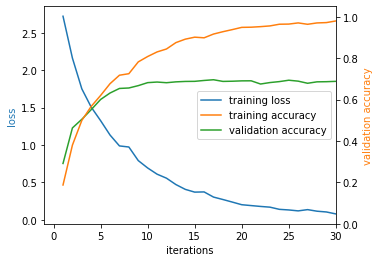

In [ ]:
plot_loss_acc(train_loss, train_acc, val_acc)

# 5. Testing Pharse

In [ ]:
path = '/content/drive/My Drive/nlp-week1/save model/'

In [ ]:
def test(model):
  model.load_state_dict(torch.load(path + 'retina_epoch24_score0.69185.pth')['model']) # choose the paramters in the model with the best performace
  model.eval()
  start_time = time.time()
  acc=[]
  f1s=[]

  for epoch in range(num_epochs):
    test_acc, f1_score = evaluate(model, test_iterator)
    acc.append(test_acc)
    f1s.append(f1_score)
  print(f'time:{time.time()-start_time:.3f}')
  return print(f'\tTest Accuracy: {np.mean(acc)*100:.2f}% | Test F1 Score: {np.mean(f1s)*100:.2f}%)')

In [ ]:
test(model)

time:15.547
	Test Accuracy: 69.64% | Test F1 Score: 69.63%)
